In [80]:
from qiskit import *
from qiskit import Aer, execute
from qiskit.circuit.library import RealAmplitudes
from qiskit import transpile
from qiskit.providers.fake_provider import FakeManilaV2
from qiskit.providers.fake_provider import FakeManila
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Session, Sampler
from qiskit.primitives import Sampler
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer

import os
import pickle
import json
import qiskit 
import scipy
import numpy as np 
import matplotlib.pyplot as plt
import warnings
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error


from collections import Counter
from collections import Counter

from typing import Dict, List

from renom_q import *
from renom_q.ml.qpca import QPCA

In [81]:
#define utility functions

def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(2,20):
        assert counter[i]==0
        
    return counter


def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)

In [82]:
data_images = np.load('images.npy')
data_labels = np.load('labels.npy')

#this converts the labels to binary.
data_label =[]
for element in data_labels:
    if element == True:
        data_label.append(1)
    else: 
        data_label.append(0)

images_new = []
for img in data_images:
    img_new = np.pad(array=img, pad_width=[2, 2], mode='constant', constant_values=0)
    images_new.append(img_new)
images_new = np.array(images_new)

252

In [83]:

#reducing dimensions
n_dim = 10
transform_img = []
for img in images_new:
    pca = PCA(n_components=n_dim).fit(img)
    reduced_img = pca.transform(img)
    transform_img.append(reduced_img)
    
# standardize
scaled_imgs = []
for img in transform_img:
    std_scale = StandardScaler().fit(img)
    img = std_scale.transform(img)
    scaled_imgs.append(img)
    
#Normalize
normalized_imgs = []
for img in scaled_imgs:
    minmax_scale = MinMaxScaler((-1, 1)).fit(img)
    img = minmax_scale.transform(img)
    normalized_imgs.append(img)
    

In [54]:
print(bool(data_label[1]==0))

False


In [85]:
#this part is to be modified
# I am doing this since the data might scrambled

mid_way = len(transform_img)//2

sample_train = []
sample_test = []

labels_train = []
labels_test = []
for i in range(len(transform_img)):
    if data_label[i] == 1:
        sample_train.append(normalized_imgs[i])
        labels_train.append(data_label[i])
    else:
        sample_test.append(normalized_imgs[i])
        labels_test.append(data_label[i])

In [69]:
# select 25 set of data for learning and 10 for test 
train_size = 25
sample_train = sample_train[:train_size]
labels_train = labels_train[:train_size]

test_size = 10
sample_test = sample_test[:test_size]
labels_test = labels_test[:test_size]

data_length1 = len(sample_train[0])

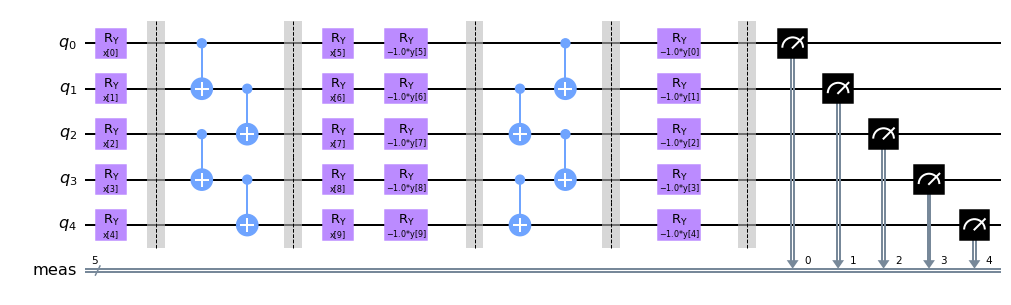

In [75]:
# parametrized circuit defining U first state
c_1 = RealAmplitudes(5, reps=1, entanglement='pairwise', insert_barriers=True, parameter_prefix='x')
    
# parametrized circuit V defining second state
c_2 = RealAmplitudes(5, reps=1, entanglement='pairwise',  insert_barriers=True, parameter_prefix='y')

# combining circuits to evaluate U^dagger V
K_circuit = c_1.copy()
K_circuit.append(c_2.inverse().decompose(), range(K_circuit.num_qubits))
K_circuit.measure_all()

# drawing resulting circuit to estimate fidelity
display(K_circuit.decompose().draw('mpl'))

#training of the model

theta_1 = sample_train[0] # label"0"
theta_2 = sample_train[2] # label"1" these zero and 1 are the actual states

# linear combinations of theta_1 and theta_2
thetas = [theta_1 + c * (theta_2 - theta_1) for c in np.linspace(0, 1, 10)]

# list the parameters
theta_list = []
for theta_ in thetas:
    theta_list.append(list(theta_1) + list(theta_2))

In [76]:
n = train_size

circuit_num = np.arange(0,n).sum()

def data_append(n, x1, x2):
    para_data = []
    #
    for i in range(n):
        for j in range(n):
            if i<j:
                para_data.append(list(x1[i])+list(x2[j]))
    #   
    return para_data

parameters_complete = data_append(n,sample_train,sample_train)
data_length = len(parameters_complete)
print(data_length)

300


In [77]:
Kqc_list = [K_circuit]*data_length 
Kqc_list_encoded =[]
for i in range(data_length):
    Kqc_list_encoded.append(Kqc_list[i].bind_parameters(parameters_complete[i]))

ValueError: Mismatching number of values and parameters. For partial binding please pass a dictionary of {parameter: value} pairs.

In [73]:
sampler = Sampler()
quantum_kernel = []
for i in range(data_length):
    job = sampler.run(Kqc_list_encoded[i])
    results = job.result()
    quantum_kernel.append(results)

IndexError: list index out of range

In [370]:
kernel = []
for i in range(circuit_num):
    kernel += [quantum_kernel[i].quasi_dists[0][0]]

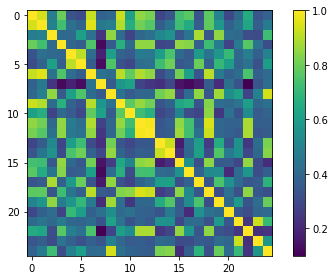

In [371]:
def Kernel_plot(A):
    
    ax = plt.imshow(A, cmap='viridis')
    plt.colorbar(ax)
    plt.tight_layout()
    plt.show()

K = np.zeros((n, n))
count = 0
for i in range(n):
    for j in range(n):
        if j<i:
            K[i,j] = K[j,i]
        else:
            if j==i:
                K[i,j] = 1
            else:
                K[i,j] = kernel[count]
                count+=1
Kernel_plot(K)

In [372]:
svc = SVC(kernel='precomputed')
# train SVM
svc.fit(K, labels_train)

# score SVM on training data
y_predict = svc.predict(K)
print('accuracy:', sum(y_predict == labels_train)/len(labels_train))

accuracy: 1.0


In [347]:
print(y_predict)

[0 0 1 0 1 1 0 0 1 0]
